<a href="https://colab.research.google.com/github/Amanshaik2004/IPL-Score-Prediction/blob/main/Authenticity_Check_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle copy.json to kaggle copy (5).json


{'kaggle copy (5).json': b'{"username":"yaseen10","key":"807f11ead33e2f0cf5ad06f90e226af0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset

Dataset URL: https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset
License(s): apache-2.0
detect-ai-generated-faces-high-quality-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip detect-ai-generated-faces-high-quality-dataset.zip -d dataset

Archive:  detect-ai-generated-faces-high-quality-dataset.zip
replace dataset/AI-face-detection-Dataset/AI/0_20241130135552_A_close-up_shot_of_a_middle-aged_genderqueer_perso.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(data_dir, class_names, img_size=(224, 224)):
    images = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist.")
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize image
                img = img / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_names.index(class_name))  # Assign label based on class index

    return np.array(images), np.array(labels)

# Define dataset paths
train_dir = "/content/dataset/AI-face-detection-Dataset"  # Training dataset folder

# Define class names
train_classes = ["real", "AI"]

# Load datasets
X, y = load_and_preprocess_data(train_dir, train_classes)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train[:1500]
y_train=y_train[:1500]
X_test=X_test[:300]
y_test=y_test[:300]
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (1500, 224, 224, 3), Labels shape: (1500,)
Testing data shape: (300, 224, 224, 3), Labels shape: (300,)


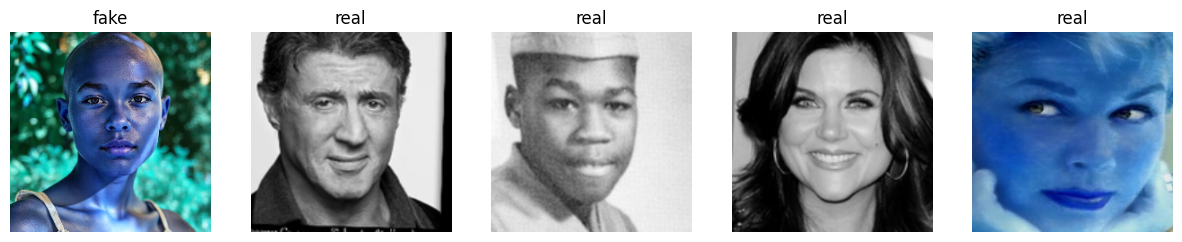

In [7]:
# Function to display sample images
def plot_sample_images(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Plot sample images from the training dataset
plot_sample_images(X_train, y_train, ["real", "fake"])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(X_train)

In [9]:
from tensorflow.keras.applications import EfficientNetB4

base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)  # Binary classification (real or fake)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
# Unfreeze the top 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 490s 39s/step - accuracy: 0.5933 - loss: 0.6462 - val_accuracy: 0.7367 - val_loss: 0.6552
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 503s 39s/step - accuracy: 0.6988 - loss: 0.5645 - val_accuracy: 0.6367 - val_loss: 0.6885
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 461s 39s/step - accuracy: 0.7366 - loss: 0.5176 - val_accuracy: 0.4933 - val_loss: 0.6903
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 485s 37s/step - accuracy: 0.7540 - loss: 0.5043 - val_accuracy: 0.3867 - val_loss: 0.6927
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 526s 39s/step - accuracy: 0.7913 - loss: 0.4577 - val_accuracy: 0.3900 - val_loss: 0.6924
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 459s 39s/step - accuracy: 0.7752 - loss: 0.4720 - val_accuracy: 0.3200 - val_loss: 0.6953
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 502s 39s/step - accuracy: 0.7921 - loss: 0.4559 - val_accuracy: 0.7733 - val_loss: 0.6746
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 504s 39s/step - accuracy: 0.8077 - loss: 0.4194 - val_accuracy: 0.